Tutorial 3: Inversions
======================

In the previous two tutorials, we introduced:

 - Pixelizations: which place a pixel-grid in the source-plane.
 - Mapper: which describe how each source-pixel maps to one or more image pixels.

However, non of this has actually helped us fit strong lens data or reconstruct the source galaxy. This is the subject
of this tutorial, where the process of reconstructing the source's light on the pixelization is called an `Inversion`.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Initial Setup__

we'll use the same strong lensing data as the previous tutorial, where:

 - The lens galaxy's light is omitted.
 - The lens galaxy's total mass distribution is an `EllIsothermal` and `ExternalShear`.
 - The source galaxy's `LightProfile` is an `EllSersic`.

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

Lets create an annular mask which traces the stongly lensed source's ring of light.

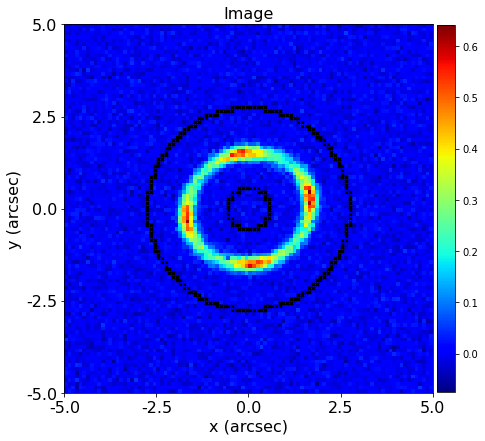

In [3]:
mask = al.Mask2D.circular_annular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    inner_radius=0.5,
    outer_radius=2.8,
)

visuals_2d = aplt.Visuals2D(mask=mask)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging, visuals_2d=visuals_2d)
imaging_plotter.figures_2d(image=True)

We now create the masked source-plane grid via the tracer, as we did in the previous tutorial.

In [4]:
imaging = imaging.apply_mask(mask=mask)

lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllIsothermal(
        centre=(0.0, 0.0),
        einstein_radius=1.6,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, angle=45.0),
    ),
    shear=al.mp.ExternalShear(elliptical_comps=(0.05, 0.05)),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=1.0)])

source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=imaging.grid)[1]

we again use the rectangular pixelization to create the mapper.

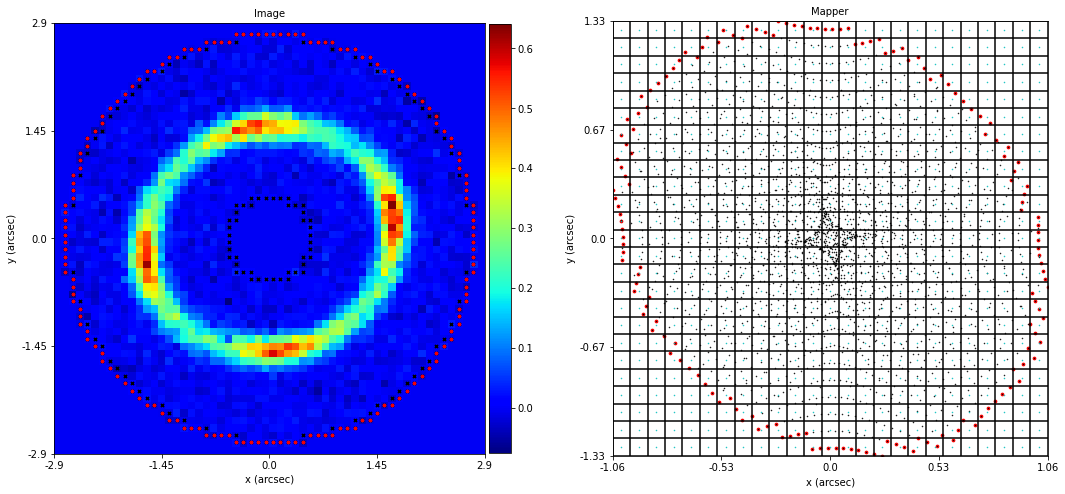

In [5]:
rectangular = al.pix.Rectangular(shape=(25, 25))

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

include_2d = aplt.Include2D(mask=True, mapper_source_grid_slim=True)

mapper_plotter = aplt.MapperPlotter(mapper=mapper, include_2d=include_2d)
mapper_plotter.subplot_image_and_mapper(image=imaging.image)

__Inversion__

Finally, we can now use the `Mapper` to reconstruct the source via an `Inversion`. I'll explain how this works in a 
second, but lets just go ahead and create the inversion first. (Ignore the regularization input below for now, 
we will cover this in the next tutorial).

In [6]:
inversion = al.Inversion(
    dataset=imaging, mapper=mapper, regularization=al.reg.Constant(coefficient=1.0)
)

The inversion has reconstructed the source's light on the rectangular pixel grid, which is called the 
`reconstruction`. This source-plane reconstruction can be mapped back to the image-plane to produce the 
`mapped_reconstructed_image`.

In [7]:
print(inversion.reconstruction)
print(inversion.mapped_reconstructed_image)

[ 4.63727465e-02  3.98928581e-02  2.41833606e-02 -8.51325966e-03
 -6.11020993e-02 -9.51702514e-02 -3.54771516e-02 -2.44615692e-02
 -1.44067072e-01  4.64053236e-02  3.36606623e-03  1.30625078e-01
 -8.50607622e-02  8.56192720e-02  1.87898266e-02 -1.34091114e-02
 -5.28816211e-03  4.79394118e-04 -1.06310454e-03 -5.69475215e-03
 -5.61579818e-03 -4.56776769e-03 -3.85375083e-03 -3.48512379e-03
 -3.33068217e-03  5.28526354e-02  4.91224677e-02  4.11704836e-02
  1.13789597e-02 -7.96227876e-02  7.67567454e-02  8.25828320e-02
  1.78208668e-02  1.93137310e-01 -1.58142227e-01 -5.74753008e-02
 -3.81426651e-02  6.51298439e-02 -4.33116931e-02 -1.58406806e-02
 -5.37289988e-02 -2.93476909e-03  7.78944901e-03  2.02604439e-03
 -1.04053538e-02 -6.58487477e-03 -4.23375410e-03 -3.50836104e-03
 -3.27093842e-03 -3.17624058e-03  6.30626925e-02  6.25738941e-02
  7.99971468e-02  9.24814024e-02  7.49123444e-02 -2.72196473e-04
 -8.66382462e-02 -1.51699377e-02 -8.49871096e-02 -6.90587966e-02
  1.28655449e-01 -4.93219

Both of these can be plotted using an `InversionPlotter`

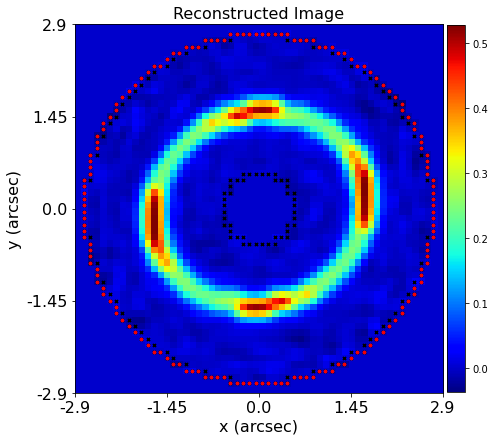

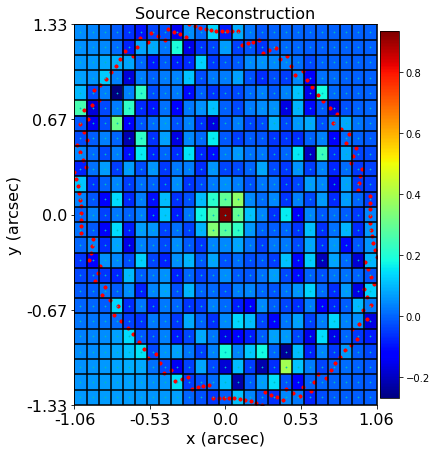

In [8]:
include_2d = aplt.Include2D(mask=True)

inversion_plotter = aplt.InversionPlotter(inversion=inversion, include_2d=include_2d)
inversion_plotter.figures_2d(reconstructed_image=True, reconstruction=True)

There we have it, we have successfully reconstructed the source using a rectangular pixel-grid. Whilst this source 
was simple (a blob of light in the centre of the source-plane), inversions come into their own when fitting sources 
with complex morphologies. 

Lets use an inversion to reconstruct a complex source!

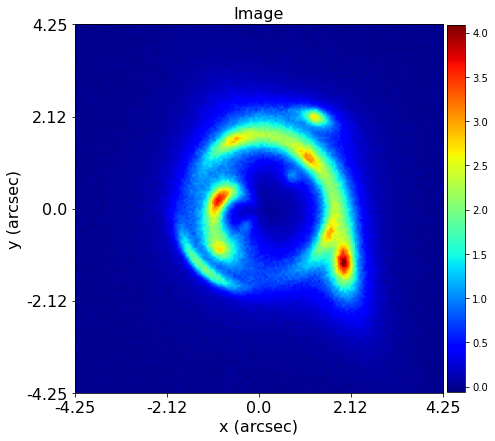

In [9]:
dataset_name = "mass_sie__source_sersic_x4"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.05,
)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.figures_2d(image=True)

This code is doing all the the same as above (setup the mask, galaxy, tracers, mapper, inversion, etc.).

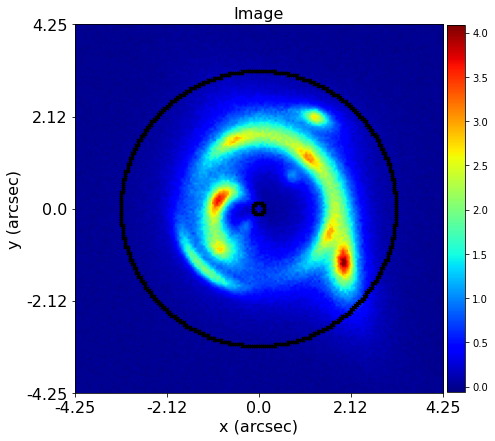

In [10]:
mask = al.Mask2D.circular_annular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    inner_radius=0.1,
    outer_radius=3.2,
)

visuals_2d = aplt.Visuals2D(mask=mask)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging, visuals_2d=visuals_2d)
imaging_plotter.figures_2d(image=True)

imaging = imaging.apply_mask(mask=mask)

lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllIsothermal(
        centre=(0.0, 0.0), einstein_radius=1.6, elliptical_comps=(0.17647, 0.0)
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=1.0)])

source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=imaging.grid)[1]

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

inversion = al.Inversion(
    dataset=imaging, mapper=mapper, regularization=al.reg.Constant(coefficient=1.0)
)

Now lets plot the complex source reconstruction.

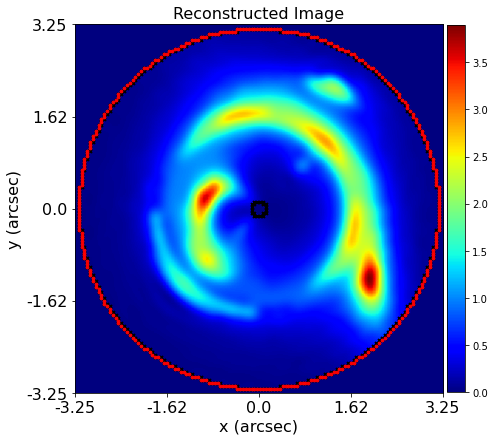

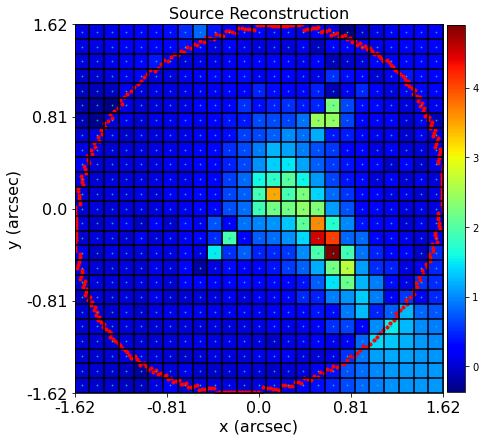

In [11]:
inversion_plotter = aplt.InversionPlotter(inversion=inversion, include_2d=include_2d)
inversion_plotter.figures_2d(reconstructed_image=True, reconstruction=True)

Pretty great, huh? If you ran the complex source pipeline in chapter 3, you'll remember that getting a model image 
that looked this good simply *was not possible*. With an inversion, we can do this with ease and without having to 
perform model-fitting with 20+ parameters for the source's light!

We will now briefly discuss how an inversion actually works, however the explanation I give in this tutorial will be 
overly-simplified. To be good at lens modeling you do not need to understand the details of how an inversion works, you 
simply need to be able to use an inversion to model a strong lens. 

To begin, lets consider some random mappings between our mapper`s source-pixels and the image.

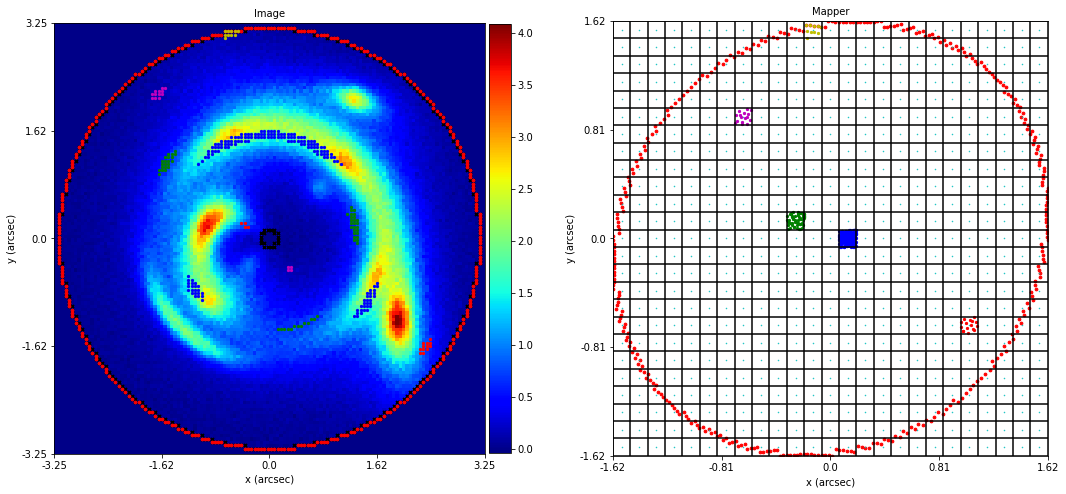

In [12]:
visuals_2d = aplt.Visuals2D(pixelization_indexes=[[445], [285], [313], [132], [11]])

mapper_plotter = aplt.MapperPlotter(
    mapper=mapper, visuals_2d=visuals_2d, include_2d=include_2d
)
mapper_plotter.subplot_image_and_mapper(image=imaging.image)

These mappings are known before the inversion reconstructs the source galaxy, which means before this inversion is
performed we know two key pieces of information:

 1) The mappings between every source-pixel and sets of image-pixels.
 2) The flux values in every observed image-pixel, which are the values we want to fit successfully.

It turns out that with these two pieces of information we can linearly solve for the set of source-pixel fluxes that 
best-fit (e.g. maximize the log likelihood) our observed image. Essentially, we set up the mappings between source and 
image pixels as a large matrix and solve for the source-pixel fluxes in an analogous fashion to how you would solve a 
set of simultaneous linear equations. This process is called a `linear inversion`.

There are three more things about a linear inversion that are worth knowing:

 1) When performing fits using light profiles, we discussed how a `model_image` was generated by convolving the light
 profile images with the data's PSF. A similar blurring operation is incorporated into the inversion, such that it 
 reconstructs a source (and therefore image) which fully accounts for the telescope optics and effect of the PSF.

 2) You may be familiar with image sub-gridding, which splits each image-pixel into a sub-pixel (if you are not 
 familiar then feel free to checkout the optional **HowToLens** tutorial on sub-gridding. If a sub-grid is used, it is 
 the mapping between every sub-pixel and source-pixel that is computed and used to perform the inversion. This prevents 
 aliasing effects degrading the image reconstruction. By default **PyAutoLens** uses sub-gridding of degree 4x4.

 3) The inversion`s solution is regularized. But wait, that`s what we'll cover in the next tutorial!

Finally, let me show you how easy it is to fit an image with an `Inversion` using a `FitImaging` object. Instead of 
giving the source galaxy a light profile, we simply pass it a `Pixelization` and regularization, and pass it to a 
tracer.

In [13]:
source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=1.0),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

Then, like before, we pass the imaging and tracer `FitImaging` object. 

We see some pretty good looking residuals, we must be fitting the lensed source accurately! In fact, we can use the
`subplot_of_planes` method to specifically visualize the inversion and plot the source reconstruction.

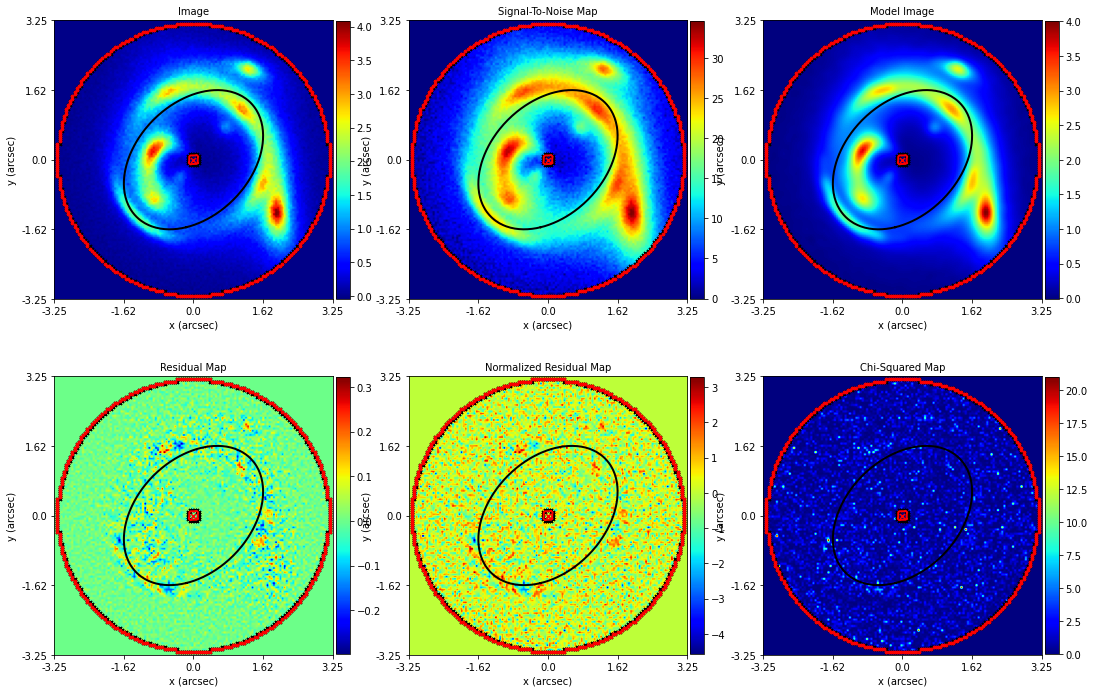

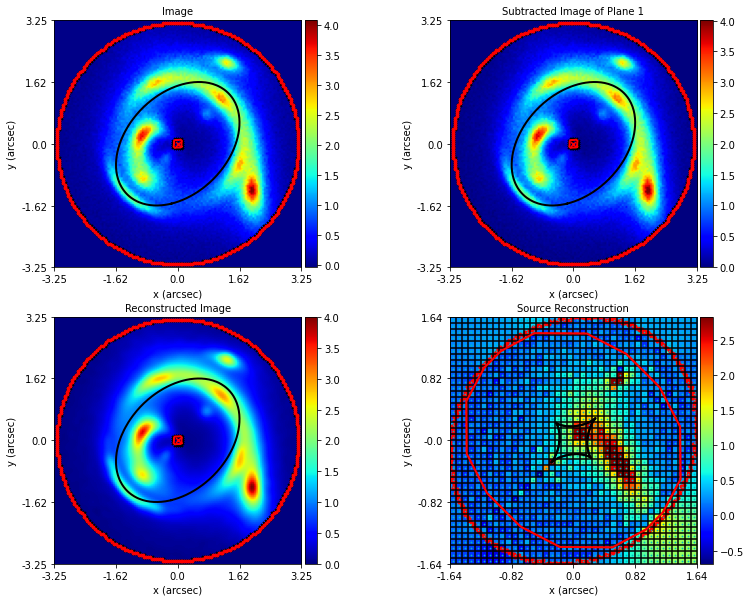

In [14]:
fit = al.FitImaging(imaging=imaging, tracer=tracer)

include_2d = aplt.Include2D(mask=True)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()
fit_imaging_plotter.subplot_of_planes(plane_index=1)

__Wrap Up__

And, we're done, here are a few questions to get you thinking about inversions:

 1) The inversion provides the maximum log likelihood solution to the observed image. Is there a problem with seeking 
 the highest likelihood solution? Is there a risk that we're going to fit other things in the image than just the 
 lensed source galaxy? What happens if you reduce the `coefficient` of the regularization object above to zero?

 2) The exterior pixels in the rectangular pixel-grid have no image-pixels in them. However, they are still given a 
 reconstructed flux. Given these pixels do not map to the data, where is this value coming from?
 
__Detailed Explanation__

If you are interested in a more detailed description of how inversions work, then checkout the documentation of the 
autolens source code for more information. In particular, you should look at the following functions in the project 
**PyAutoArray**:

 autoarray.inversions.mappers.mapping_matrix
 autoarray.opterators.convolution.convolve_mapping_matrix
 autoarray.opterators.inversions.regularization.Regularization
 autoarray.opterators.inversions.inversions.Inversion

GitHub links to these modules are given below:

https://github.com/Jammy2211/PyAutoArray/blob/master/autoarray/operators/convolver.py
https://github.com/Jammy2211/PyAutoArray/blob/master/autoarray/inversion/mappers.py
https://github.com/Jammy2211/PyAutoArray/blob/master/autoarray/inversion/regularization.py
https://github.com/Jammy2211/PyAutoArray/blob/master/autoarray/inversion/inversions.py